In [9]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/resources/datasets/05c_Howard_MetaAlzheimerReview_DBS-TMS_Coordinates/metadata/master_list.xlsx'
sheet = 'Sheet1' #'master_list_proper_subjects' ?

In [10]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=None, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()
data_df

,Study,DOI,RCT_Design,Age_range,CDR,Active_N,Sham_N,Mean_Age,Active_Age,Sham_Age,...,Memory_Cohen_s_D,Stimulation_site,Stim_Coordinate,Included,Exclusion_Reason,roi_path,roi_path_old,subject,CNM_Damage_Roi_old,CNM_Damage_Roi_new
0,"Qin et al., 2023",10.3389/fncir.2023.1202671,Parallel,NaN,≦2,26.0,25.0,67.0,67.36 ± 6.98,66.25 ± 8.07,...,0.758018,"Left DLPFC, left lateral temporal","[-44,40,29], [-69, -8, -10]",0.0,Multifocal,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,NaN,Qin_et_al___2023,-0.487645,-0.487645
1,"Wu et al., 2024",10.1136/gpsych-2023-101106,Parallel,≧50,0.5-2,20.0,22.0,67.0,66.8 ± 8.84,65.32 ± 7.31,...,-0.100000,Left DLPFC,"[-38, 44, 26]",1.0,iTBS,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,NaN,Wu_et_al___2024,-0.685000,-0.681262
2,"Moussavi et al., 2024",10.1016/j.neurot.2024.e00331,Parallel,>55,1∼2,53.0,51.0,73.0,73.3 ± 6.9,75 ± 9.1,...,NaN,Bilateral DLPFC,"[-41.1, 36, 38], [41.1, 36, 38]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Moussavi_et_al___2024,-0.369729,-0.370000
3,"Koch et al., 2018",https://doi.org/10.1016/j.neuroimage.2017.12.048,NaN,>65,0.5–1,14.0,NaN,70.0,70 ± 5.1,NaN,...,NaN,Precuneus,"[0, -70, 44]",0.0,Duplicated,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Koch_et_al___2018,0.540000,0.540000
4,"Cotelli et al., 2011",10.1136/jnnp.2009.197848,Parallel,NaN,NaN,5.0,5.0,71.0,71.2 ± 6.1,74.4 ± 3.8,...,NaN,Left DLPFC,"[-29, 23, 59]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Cotelli_et_al___2011,-0.510000,0.410000
5,"Ahmed et al., 2012 (1 Hz)",10.1007/s00415-011-6128-4,Parallel,60-82,NaN,15.0,15.0,65.0,65.9 ± 5.9,68.3 ± 4.9,...,NaN,Bilateral DLPFC,"[-22.7, 38.9, 44], [22.7, 38.9, 44]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,NaN,Ahmed_et_al___2012__1_Hz_,0.430000,0.430000
6,"Ahmed et al., 2012 (20 Hz)",10.1007/s00415-011-6128-4,Parallel,60-82,NaN,15.0,15.0,65.0,65.9 ± 5.9,68.3 ± 4.9,...,NaN,Bilateral DLPFC,"[-22.7, 38.9, 44], [22.7, 38.9, 44]",0.0,low frequency,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,NaN,Ahmed_et_al___2012__1_Hz_,0.430000,0.430000
7,"Li et al., 2021",10.1016/j.brs.2021.01.012,Parallel,NaN,NaN,37.0,38.0,65.0,65.97 ± 8.47,64.58 ± 7.88,...,NaN,Left DLPFC,"[-44,40,29]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Li_et_al___2021,-0.615157,-0.620000
8,"Wei et al., 2022",10.1016/j.psychres.2022.114721,Parallel,55–85,0.5–2,29.0,27.0,70.0,70 ± 8.68,71.67 ± 7.16,...,0.207207,Left lateral parietal location,"[-47, -68, 36]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Wei_et_al___2022,0.620000,0.610000
9,"Koch et al., 2022",10.1093/brain/awac285,Parallel,50–85,0.5–1,25.0,25.0,75.0,75 ± 5.6,72.3 ± 7.2,...,NaN,Precuneus,"[0, -70, 44]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Koch_et_al___2022,0.545000,0.545000



# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [11]:
data_df.columns

Index(['Study', 'DOI', 'RCT_Design', 'Age_range', 'CDR', 'Active_N', 'Sham_N',
       'Mean_Age', 'Active_Age', 'Sham_Age', 'Active_M_F', 'Sham_M_F',
       'Active_Education__Yrs_', 'Sham_Education__Yrs_',
       'Active_AD_Treatment_Proportion', 'Diagnosis', 'Diagnostic_Criteria',
       'Stim_Type', 'Frequency', 'Intensity', 'Navigation',
       'Total_Pulses_session', 'session', 'Total_pulses',
       'Overall_Cognition_Test', 'Overall_Cognition_Cohen_s_D', 'Redo_test',
       'cohens_D_redo', 'Verbal_Memory_Test', 'Memory_Cohen_s_D',
       'Stimulation_site', 'Stim_Coordinate', 'Included', 'Exclusion_Reason',
       'roi_path', 'roi_path_old', 'subject', 'CNM_Damage_Roi_old',
       'CNM_Damage_Roi_new'],
      dtype='object')

In [12]:
drop_list = ['cohens_D_redo']

In [13]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
data_df

,Study,DOI,RCT_Design,Age_range,CDR,Active_N,Sham_N,Mean_Age,Active_Age,Sham_Age,...,Memory_Cohen_s_D,Stimulation_site,Stim_Coordinate,Included,Exclusion_Reason,roi_path,roi_path_old,subject,CNM_Damage_Roi_old,CNM_Damage_Roi_new
0,"Qin et al., 2023",10.3389/fncir.2023.1202671,Parallel,NaN,≦2,26.0,25.0,67.0,67.36 ± 6.98,66.25 ± 8.07,...,0.758018,"Left DLPFC, left lateral temporal","[-44,40,29], [-69, -8, -10]",0.0,Multifocal,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,NaN,Qin_et_al___2023,-0.487645,-0.487645
1,"Wu et al., 2024",10.1136/gpsych-2023-101106,Parallel,≧50,0.5-2,20.0,22.0,67.0,66.8 ± 8.84,65.32 ± 7.31,...,-0.100000,Left DLPFC,"[-38, 44, 26]",1.0,iTBS,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,NaN,Wu_et_al___2024,-0.685000,-0.681262
2,"Moussavi et al., 2024",10.1016/j.neurot.2024.e00331,Parallel,>55,1∼2,53.0,51.0,73.0,73.3 ± 6.9,75 ± 9.1,...,NaN,Bilateral DLPFC,"[-41.1, 36, 38], [41.1, 36, 38]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Moussavi_et_al___2024,-0.369729,-0.370000
3,"Koch et al., 2018",https://doi.org/10.1016/j.neuroimage.2017.12.048,NaN,>65,0.5–1,14.0,NaN,70.0,70 ± 5.1,NaN,...,NaN,Precuneus,"[0, -70, 44]",0.0,Duplicated,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Koch_et_al___2018,0.540000,0.540000
4,"Cotelli et al., 2011",10.1136/jnnp.2009.197848,Parallel,NaN,NaN,5.0,5.0,71.0,71.2 ± 6.1,74.4 ± 3.8,...,NaN,Left DLPFC,"[-29, 23, 59]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Cotelli_et_al___2011,-0.510000,0.410000
5,"Ahmed et al., 2012 (1 Hz)",10.1007/s00415-011-6128-4,Parallel,60-82,NaN,15.0,15.0,65.0,65.9 ± 5.9,68.3 ± 4.9,...,NaN,Bilateral DLPFC,"[-22.7, 38.9, 44], [22.7, 38.9, 44]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,NaN,Ahmed_et_al___2012__1_Hz_,0.430000,0.430000
7,"Li et al., 2021",10.1016/j.brs.2021.01.012,Parallel,NaN,NaN,37.0,38.0,65.0,65.97 ± 8.47,64.58 ± 7.88,...,NaN,Left DLPFC,"[-44,40,29]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Li_et_al___2021,-0.615157,-0.620000
8,"Wei et al., 2022",10.1016/j.psychres.2022.114721,Parallel,55–85,0.5–2,29.0,27.0,70.0,70 ± 8.68,71.67 ± 7.16,...,0.207207,Left lateral parietal location,"[-47, -68, 36]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Wei_et_al___2022,0.620000,0.610000
9,"Koch et al., 2022",10.1093/brain/awac285,Parallel,50–85,0.5–1,25.0,25.0,75.0,75 ± 5.6,72.3 ± 7.2,...,NaN,Precuneus,"[0, -70, 44]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Koch_et_al___2022,0.545000,0.545000
10,"Jia et al., 2021",10.3389/fnagi.2021.693611,Parallel,55–85,0.5–2,35.0,34.0,71.0,71.41 ± 8.85,73.41 ± 7.73,...,0.319231,Left lateral parietal site,"[-47, -68, 36]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Jia_et_al___2021,0.605000,0.610000


**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

Set the parameters for dropping rows

In [14]:
data_df.columns

Index(['Study', 'DOI', 'RCT_Design', 'Age_range', 'CDR', 'Active_N', 'Sham_N',
       'Mean_Age', 'Active_Age', 'Sham_Age', 'Active_M_F', 'Sham_M_F',
       'Active_Education__Yrs_', 'Sham_Education__Yrs_',
       'Active_AD_Treatment_Proportion', 'Diagnosis', 'Diagnostic_Criteria',
       'Stim_Type', 'Frequency', 'Intensity', 'Navigation',
       'Total_Pulses_session', 'session', 'Total_pulses',
       'Overall_Cognition_Test', 'Overall_Cognition_Cohen_s_D', 'Redo_test',
       'cohens_D_redo', 'Verbal_Memory_Test', 'Memory_Cohen_s_D',
       'Stimulation_site', 'Stim_Coordinate', 'Included', 'Exclusion_Reason',
       'roi_path', 'roi_path_old', 'subject', 'CNM_Damage_Roi_old',
       'CNM_Damage_Roi_new'],
      dtype='object')

In [15]:
column = 'Included'  # The column you'd like to evaluate
condition = 'not'  # Thecondition to check ('equal', 'above', 'below', 'not')
value = 1 # The value to compare against

In [16]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
data_df

,Study,DOI,RCT_Design,Age_range,CDR,Active_N,Sham_N,Mean_Age,Active_Age,Sham_Age,...,Memory_Cohen_s_D,Stimulation_site,Stim_Coordinate,Included,Exclusion_Reason,roi_path,roi_path_old,subject,CNM_Damage_Roi_old,CNM_Damage_Roi_new
1,"Wu et al., 2024",10.1136/gpsych-2023-101106,Parallel,≧50,0.5-2,20.0,22.0,67.0,66.8 ± 8.84,65.32 ± 7.31,...,-0.100000,Left DLPFC,"[-38, 44, 26]",1.0,iTBS,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,NaN,Wu_et_al___2024,-0.685000,-0.681262
2,"Moussavi et al., 2024",10.1016/j.neurot.2024.e00331,Parallel,>55,1∼2,53.0,51.0,73.0,73.3 ± 6.9,75 ± 9.1,...,NaN,Bilateral DLPFC,"[-41.1, 36, 38], [41.1, 36, 38]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Moussavi_et_al___2024,-0.369729,-0.370000
4,"Cotelli et al., 2011",10.1136/jnnp.2009.197848,Parallel,NaN,NaN,5.0,5.0,71.0,71.2 ± 6.1,74.4 ± 3.8,...,NaN,Left DLPFC,"[-29, 23, 59]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Cotelli_et_al___2011,-0.510000,0.410000
5,"Ahmed et al., 2012 (1 Hz)",10.1007/s00415-011-6128-4,Parallel,60-82,NaN,15.0,15.0,65.0,65.9 ± 5.9,68.3 ± 4.9,...,NaN,Bilateral DLPFC,"[-22.7, 38.9, 44], [22.7, 38.9, 44]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,NaN,Ahmed_et_al___2012__1_Hz_,0.430000,0.430000
7,"Li et al., 2021",10.1016/j.brs.2021.01.012,Parallel,NaN,NaN,37.0,38.0,65.0,65.97 ± 8.47,64.58 ± 7.88,...,NaN,Left DLPFC,"[-44,40,29]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Li_et_al___2021,-0.615157,-0.620000
8,"Wei et al., 2022",10.1016/j.psychres.2022.114721,Parallel,55–85,0.5–2,29.0,27.0,70.0,70 ± 8.68,71.67 ± 7.16,...,0.207207,Left lateral parietal location,"[-47, -68, 36]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Wei_et_al___2022,0.620000,0.610000
9,"Koch et al., 2022",10.1093/brain/awac285,Parallel,50–85,0.5–1,25.0,25.0,75.0,75 ± 5.6,72.3 ± 7.2,...,NaN,Precuneus,"[0, -70, 44]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Koch_et_al___2022,0.545000,0.545000
10,"Jia et al., 2021",10.3389/fnagi.2021.693611,Parallel,55–85,0.5–2,35.0,34.0,71.0,71.41 ± 8.85,73.41 ± 7.73,...,0.319231,Left lateral parietal site,"[-47, -68, 36]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Jia_et_al___2021,0.605000,0.610000
11,"Saitoh et al., 2022 (90%RTM)",10.3389/fnagi.2022.993306,Parallel,NaN,NaN,13.0,NaN,77.0,77.2,NaN,...,NaN,Bilateral DLPFC,"[-29, 23, 59], [29, 23, 59]",1.0,NaN,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Saitoh_et_al___2022__90_RTM_,0.353568,0.353000
12,"Kuhn et al., 2015",https://doi.org/10.1038/mp.2014.32,Crossover,57-90,<0.5,6.0,NaN,69.0,69.5 ± 7.7,NaN,...,NaN,Bilateral NBM,"[-20, -7.1, -8.6], [20, -7.1, -8.6]",1.0,no sham arm,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,/Volumes/HowExp/datasets/05c_Howard_MetaAlzhei...,Kuhn_et_al___2015,0.045051,0.451000


Regress out Covariates

In [48]:
data_df.columns

Index(['Study', 'DOI', 'RCT_Design', 'Age_range', 'CDR', 'Active_N', 'Sham_N',
       'Mean_Age', 'Active_Age', 'Sham_Age', 'Active_M_F', 'Sham_M_F',
       'Active_Education__Yrs_', 'Sham_Education__Yrs_',
       'Active_AD_Treatment_Proportion', 'Diagnosis', 'Diagnostic_Criteria',
       'Stim_Type', 'Frequency', 'Intensity', 'Navigation',
       'Total_Pulses_session', 'session', 'Total_pulses',
       'Overall_Cognition_Test', 'Overall_Cognition_Cohen_s_D', 'Redo_test',
       'cohens_D_redo', 'Verbal_Memory_Test', 'Memory_Cohen_s_D',
       'Stimulation_site', 'Stim_Coordinate', 'Included', 'Exclusion_Reason',
       'roi_path', 'roi_path_old', 'subject', 'CNM_Damage_Roi_old',
       'CNM_Damage_Roi_new', 'spatial_sign'],
      dtype='object')

In [49]:
dependent_variable_list = ['cohens_D_redo']
regressors = ['Stimulation_site', 'Frequency']

In [50]:
#Impute covariates in if desired
for col in regressors:
    if data_df[col].dtype == 'O':  # object/categorical
        data_df[col] = data_df[col].fillna(data_df[col].mode()[0])
    else:  # numeric
        data_df[col] = data_df[col].fillna(data_df[col].mean())
data_df[regressors].isna().sum()

/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_92222/1465701550.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[col] = data_df[col].fillna(data_df[col].mode()[0])


Stimulation_site    0
Frequency           0
dtype: int64

In [51]:
from calvin_utils.statistical_utils.regression_utils import RegressOutCovariates
data_df, adjusted_dep_vars_list = RegressOutCovariates.run(df=data_df, dependent_variable_list=dependent_variable_list, covariates_list=regressors)
print(adjusted_dep_vars_list)


 Formula for cohens_D_redo: 
 cohens_D_redo ~ Stimulation_site + Frequency
['cohens_D_redo_residual']


/Users/cu135/Software_Local/calvin_utils_project/calvin_utils_project/calvin_utils/statistical_utils/regression_utils.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{indep_var}_residual"] = residuals


**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
data_df.columns

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['TOTAL11']

In [ ]:
# data_df = cal_palm.standardize_columns(cols_not_to_standardize)

Do Miscellaneous Data Cleaning

In [4]:
# data_df = data_df[(data_df['Pre_Post_Memory_Effect_Size__Cohen_s_D_'] >= -1) & (data_df['Pre_Post_Memory_Effect_Size__Cohen_s_D_'] <= 1)]

In [18]:
data_df.columns

Index(['Study', 'DOI', 'RCT_Design', 'Age_range', 'CDR', 'Active_N', 'Sham_N',
       'Mean_Age', 'Active_Age', 'Sham_Age', 'Active_M_F', 'Sham_M_F',
       'Active_Education__Yrs_', 'Sham_Education__Yrs_',
       'Active_AD_Treatment_Proportion', 'Diagnosis', 'Diagnostic_Criteria',
       'Stim_Type', 'Frequency', 'Intensity', 'Navigation',
       'Total_Pulses_session', 'session', 'Total_pulses',
       'Overall_Cognition_Test', 'Overall_Cognition_Cohen_s_D', 'Redo_test',
       'cohens_D_redo', 'Verbal_Memory_Test', 'Verbal_Memory_Cohen_s_D',
       'Stimulation_site', 'Stim_Coordinate', 'Included', 'Exclusion_Reason',
       'roi_path', 'roi_path_old', 'Subject', 'CNM_Damage_Roi_old',
       'CNM_Damage_Roi_new'],
      dtype='object')

In [35]:
import numpy as np
data_df['spatial_sign'] = np.where(data_df['CNM_Damage_Roi_old'] > 0, 'Positive', 'Negative')

/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_92222/3659821436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['spatial_sign'] = np.where(data_df['CNM_Damage_Roi_old'] > 0, 'Positive', 'Negative')


# A - Simple BoxPLot

In [36]:
data_df.columns

Index(['Study', 'DOI', 'RCT_Design', 'Age_range', 'CDR', 'Active_N', 'Sham_N',
       'Mean_Age', 'Active_Age', 'Sham_Age', 'Active_M_F', 'Sham_M_F',
       'Active_Education__Yrs_', 'Sham_Education__Yrs_',
       'Active_AD_Treatment_Proportion', 'Diagnosis', 'Diagnostic_Criteria',
       'Stim_Type', 'Frequency', 'Intensity', 'Navigation',
       'Total_Pulses_session', 'session', 'Total_pulses',
       'Overall_Cognition_Test', 'Overall_Cognition_Cohen_s_D', 'Redo_test',
       'cohens_D_redo', 'Verbal_Memory_Test', 'Memory_Cohen_s_D',
       'Stimulation_site', 'Stim_Coordinate', 'Included', 'Exclusion_Reason',
       'roi_path', 'roi_path_old', 'subject', 'CNM_Damage_Roi_old',
       'CNM_Damage_Roi_new', 'spatial_sign'],
      dtype='object')

In [52]:
category_col = 'spatial_sign'
y_col = 'cohens_D_redo_residual'

In [53]:
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/ccm_memory/results/tms_meta_analysis/redo_for_simon'

/Users/cu135/Software_Local/calvin_utils_project/.venv_calvin/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cu135/Software_Local/calvin_utils_project/.venv_calvin/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cu135/Software_Local/calvin_utils_project/.venv_calvin/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


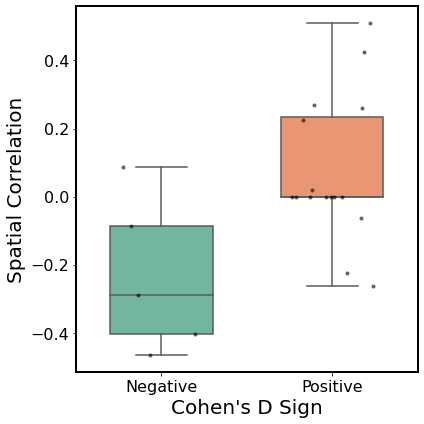

In [54]:
from calvin_utils.statistical_utils.boxplot import BoxJitterPlotter
bjp = BoxJitterPlotter(figsize=(6,6))
bjp.plot(data_df, group_col=category_col, y_col=y_col, title='', out_dir=out_dir, xlabel="Cohen's D Sign", ylabel="Spatial Correlation")

In [55]:
from scipy.stats import ttest_ind

# Get the unique groups
groups = data_df[category_col].unique()
if len(groups) != 2:
    raise ValueError("T-test requires exactly two groups.")

# Split the data by group
group1 = data_df[data_df[category_col] == groups[0]][y_col].dropna()
group2 = data_df[data_df[category_col] == groups[1]][y_col].dropna()

# Run independent t-test
ttest_ind(group1, group2)

TtestResult(statistic=-2.7571602367142027, pvalue=0.012538726431367326, df=19.0)

In [33]:
data_df.columns

Index(['Unnamed__0', 'patient_id', 'score', 'average_dice_coefficient',
       'optimizer', 'predictions'],
      dtype='object')

In [36]:
import numpy as np
np.std(obs.values-pred.values)

6.284784857897618

In [37]:
len(obs)

26

In [44]:
data_df.columns

Index(['Unnamed__0', 'patient_id', 'actual_score', 'dice', 'optimizer',
       'pred_score', 'predictions'],
      dtype='object')

In [45]:
obs = data_df[data_df['optimizer'] == 0]['actual_score']
pred = data_df[data_df['optimizer'] == 1]['predictions']

t_stat, p_value = ttest_ind(obs, pred, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")

T-statistic: -6.3940, p-value: 3.6938e-04


/Users/cu135/.virtualenvs/Python_3.7.7_nimlab/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [46]:
import numpy as np
from scipy.stats import t

# Means and standard deviations for the two groups
mean1 = np.mean(obs)
std1 = np.std(obs)
n1 = len(group1)

mean2 = 21
std2 = 21/np.sqrt(26)
n2 = len(group2)

# Calculate t-statistic for independent samples (unequal variance)
se = np.sqrt(std1**2 / n1 + std2**2 / n2)
t_stat_manual = (mean1 - mean2) / se

# Degrees of freedom (Welch-Satterthwaite equation)
df = (std1**2 / n1 + std2**2 / n2)**2 / (
    (std1**2 / n1)**2 / (n1 - 1) + (std2**2 / n2)**2 / (n2 - 1)
)

# Two-tailed p-value
p_value_manual = 2 * t.sf(np.abs(t_stat_manual), df)

print(f"Manual t-statistic: {t_stat_manual:.4f}, p-value: {p_value_manual:.4e}")

Manual t-statistic: -2.6110, p-value: 3.2262e-02


In [9]:
(( (25*(105)**2) + (8 * 48**2) ) / 33)**0.5 / (35)**0.5

15.956027237216825

In [4]:
16 * (9**0.5)

48.0

# B - Horizontal Box Plot
- Import a CSV with labels in the first column and observations across the other columns. Each row gets a boxplot. 

In [ ]:
data_path =''

In [ ]:
import pandas as pd
df = pd.read_csv(data_path)

In [ ]:
from calvin_utils.statistical_utils.boxplot import plot_horizontal_boxplot_with_stats
plot_horizontal_boxplot_with_stats(
    df,
    xlabel="x",
    out_dir=out_dir
)

Simple boxplot from CSV